In [31]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import timeit


%matplotlib notebook

### Local Functions

In [32]:
def TS_Describe_stats(data, valType):
    mindate = data['datetime'].min()
    maxdate = data['datetime'].max()
    daterez = data['datetime'][1]-data['datetime'][0]
    minval = data[valType].min()
    maxval = data[valType].max()
    aveval = data[valType].mean()
    medval = data[valType].median()
    print("Date range = {} to {}".format(mindate, maxdate))
    print("Timestep is {}".format(daterez))
    print("Value range is {} to {}".format(minval, maxval))   
    print("Average value is {}".format(aveval))
    print("Median value is {}".format(medval)) 
    print('\n')
    
    
### The rain gage file maker function for a single rain gauge ### 
# Input_Precip_df - A dataframe of timerseries precipitation data 
# Precip_column_Name - The column in the above Input_Precip_df to use
# gagFileFolder-  The relative path to the gag file formatted as 
# StartDate - Desired start date of the run (note will work if no hours or minutes but best to add them)
# EndDate  - Desired end date of the run 
# Lat lon of the gauge site, important for GSSHA calculations
# GageName - name of gauge, not so important 
# RainSeries_timestep_Mins - The timestep of the input rainfall data from Input_Precip_df
# ImpPrecip_units - Units of the precip df, this converts it to mm before running in GSSHA as mm is the default GSSHA units
    
def make_rain_gag_file(PrjName, Input_Precip_df, Precip_column_Name, gagFileFolder, StartDate, EndDate, Lat, Lon, 
                       GageName, RainSeries_timestep_Mins, ImpPrecip_units="Inches"):

    Full_Frame = Input_Precip_df   # read in data 
    SliceFrame = Full_Frame[StartDate:EndDate]

    # Format date string for dumb file 
    SliceFrame_format = SliceFrame.copy()
    SliceFrame_format['da'] = SliceFrame_format.index.strftime('%Y %m %d %H %M')
    SliceFrame_format['datedumb'] = SliceFrame_format['da'].str[:]

    # Pull extranious columns 
    SliceFrame_format = SliceFrame_format[['datedumb', Precip_column_Name]]

    # Turn rain in to rain MM 
    if ImpPrecip_units == "Inches": 
        SliceFrame_format[Precip_column_Name+"_mm"] = SliceFrame_format[Precip_column_Name]*25.4 
        Precip_column_Name = Precip_column_Name+"_mm"
        
    # Round off the number of significant figs
    sigfigs = 3
    SliceFrame_format[Precip_column_Name] = SliceFrame_format[Precip_column_Name].round(sigfigs).apply(lambda x: 
                                                                                                 '{0:g}'.format(float(x)))
    # Put the GAGES card on EVery single row 
    SliceFrame_format["trash"] = "GAGES"

    # reorder columns 
    SliceFrame_format = SliceFrame_format[["trash", "datedumb", Precip_column_Name]]

    # Print it off to a txt file with no header, no index and space separator
    FileNamePlace = os.path.join(gagFileFolder, "{}.gag".format(PrjName))
    SliceFrame_format.to_csv(FileNamePlace, index=False, sep=' ', header = False) 

    # Remove dumb double quotes 
    with open(FileNamePlace,'r') as file:
        data = file.read()
        data = data.replace('"','')
    with open(FileNamePlace,'w') as file:    
        file.write(data)

    # Create the required header lines for WMS gag  files 
    AddLine = 'EVENT "Rain Gage" \nNRGAG 1 \nNRPDS {}\nCOORD {} {} "{}"'.format(len(SliceFrame_format),Lat, Lon, GageName)  

    with open(FileNamePlace, "r+") as f:
        old = f.read() # read everything in the file
        f.seek(0) # rewind
        f.write("{}\n".format(AddLine) + old) # write the new line before

    # Calculate the number of minutes to run the damn thing. 
    Run_Length_mins = RainSeries_timestep_Mins*len(SliceFrame_format)
    print("Simulation time is {} minutes".format(Run_Length_mins))
    print("number of time rows is {}".format(len(SliceFrame_format)))
    
    return Run_Length_mins, SliceFrame_format


######  need to write in the rangauge dates (runtime) in the .prj file this does that and other modicifations to it ###
# file_path = where the .prj lives
# prj_name = should just be existing variable of PrjName
# card_name = the parameter to modify in the .prj file 
# Mod_Value = the NEW value to put in the file 


def modify_prj_file(file_path, prj_name, card_name, Mod_Value):
    df = pd.read_csv(os.path.join(file_path, "{}.prj".format(prj_name)), names=["moo"] )  # note names=moo is to make a column that will then get chopped off by numpy savetxt
    singleCol = df.columns[0]     # All data was read into a single column with pandas
    idx_tottime = df.loc[df[singleCol].str.contains(card_name, case=False)].index[0]  # this identifies the index of the TOT_TIME card
    df.loc[idx_tottime] = "{}        {}".format(card_name, Mod_Value)
    
    # Save the df back to a prj file (the np formulation seems to write better than the pd to csv one)
    np.savetxt(os.path.join(file_path, "{}.prj".format(prj_name)), df.values, fmt="%s")


#### Process outlet file from GSSHA into a pandas dataframe ###
# StartDate - has to have hours and minutes e.g. 00:00
# OutletFile  - the gssha .otl file from the project 

def process_otl_file(StartDate, OutletFile):

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
    
    # read in the outlet file 
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)
    
    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["datetime"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))
    
    # Set the index to the date
    OutHydro.set_index("datetime", inplace=True)
    
    return OutHydro



#### Process streamflow datasets from da streamflow dataframe  ### 

def Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate, 
                        StreamFlowObs_resample_Timestep_mins = 60):
    SliceFrame = Input_Stream_df[StartDate:EndDate]
    
    # USGS data is amazingly terrible, it does not have consistent timesteps, fix this issue here
    mins = StreamFlowObs_resample_Timestep_mins
    SliceFrame = SliceFrame.resample('{}T'.format(mins)).mean().interpolate()

    return SliceFrame[[StreamFlow_column_Name]]



### Calculate NSE of predictions and obs  #### 
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


#### Open up the parameters file and replace certain keys with certain values   #### 
def cmt_prama_jama(MapTableFile, Param, Val):
    with open(MapTableFile, 'r') as file :    # Read in the file 
        filedata = file.read()

    filedata = filedata.replace(Param, Val)  # Replace the target paramater(s)

    with open(MapTableFile, 'w') as file:   # Write the file out again
        file.write(filedata)

In [33]:
####### RUN THIS CELL ONLY WHEN SAVING A FRESH PROJECT FILE FROM WMS in the RUN directory!

#### Nuke out the PRISTINE_MODEL_COPY directory to start fresh
#for f in os.listdir("PRISTINE_MODEL_COPY"):  os.remove(os.path.join("PRISTINE_MODEL_COPY", f))

#### This will copy out the project files to the working directory  
#copy_tree("RUN", 'PRISTINE_MODEL_COPY')

#### Copy in GSSHA exe
#distutils.file_util.copy_file(os.path.join(".", "data", "gssha.exe"), 'PRISTINE_MODEL_COPY')

#### Nuke out the RUN directory to start fresh
#for f in os.listdir("RUN"):  os.remove(os.path.join("RUN", f))

# Rainfall data 

<IPython.core.display.Javascript object>


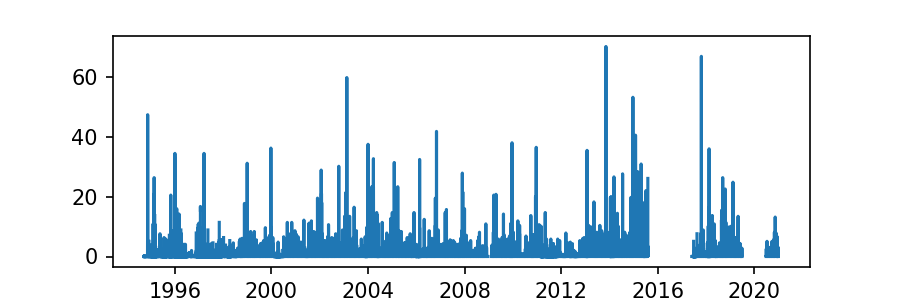

Date range = 1994-09-22 09:00:00 to 2020-12-31 23:00:00
Timestep is 0 days 01:00:00
Value range is 0.0 to 70.358
Average value is 0.11355604797212336
Median value is 0.0




<IPython.core.display.Javascript object>


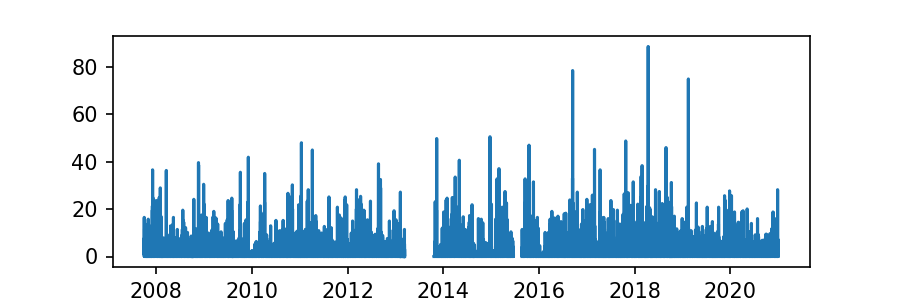

Date range = 2007-10-01 00:00:00 to 2020-12-31 23:00:00
Timestep is 0 days 01:00:00
Value range is 0.0 to 88.646
Average value is 0.7028017270196392
Median value is 0.0




<IPython.core.display.Javascript object>


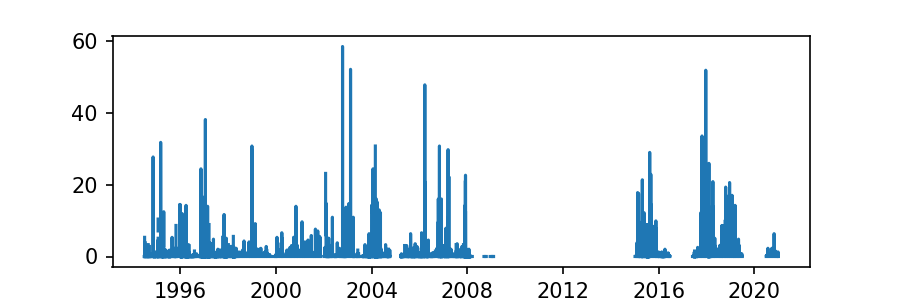

Date range = 1994-07-01 01:00:00 to 2020-12-31 23:00:00
Timestep is 0 days 01:00:00
Value range is 0.0 to 58.42
Average value is 0.06080984871787594
Median value is 0.0




In [34]:
# Import the three closest rainfall stations into a rainfall file 

# Import KAHAKULOA station 
KAHAKULOARain = pd.read_csv(os.path.join(".", "data/precip", 'KHKH1.csv'))
KAHAKULOARain['DateTime'] = pd.to_datetime(KAHAKULOARain['DateTime'], errors='coerce')
# Clean data 
KAHAKULOARain = KAHAKULOARain[['DateTime', 'RF_mm']]
KAHAKULOARain.rename(columns={'DateTime': 'datetime'}, inplace=True)
# Plot data 
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(KAHAKULOARain['datetime'],KAHAKULOARain['RF_mm'], '-',label='Rainfall Inches')
TS_Describe_stats(KAHAKULOARain, 'RF_mm')

# Import PUU_KUKIv2 station 
PUU_KUKIv2 = pd.read_csv(os.path.join(".", "data/precip", 'USGS_uv205327156351102.csv'))
PUU_KUKIv2['DateTime'] = pd.to_datetime(PUU_KUKIv2['DateTime'], errors='coerce')
# Clean data 
PUU_KUKIv2 = PUU_KUKIv2[['DateTime', 'RF_mm']]
PUU_KUKIv2.rename(columns={'DateTime': 'datetime'}, inplace=True)
# Plot data 
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(PUU_KUKIv2['datetime'],PUU_KUKIv2['RF_mm'], '-',label='Rainfall Inches')
TS_Describe_stats(PUU_KUKIv2, 'RF_mm')

# Import WAILUKU_Rain station 
WAILUKU_Rain = pd.read_csv(os.path.join("..", "..", "Data/Rainfall_data/Yufen_paper", 'WUKH1.csv'))
WAILUKU_Rain['DateTime'] = pd.to_datetime(WAILUKU_Rain['DateTime'], errors='coerce')
# Clean data 
WAILUKU_Rain = WAILUKU_Rain[['DateTime', 'RF_mm']]
WAILUKU_Rain.rename(columns={'DateTime': 'datetime'}, inplace=True)
# Plot data 
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(WAILUKU_Rain['datetime'],WAILUKU_Rain['RF_mm'], '-',label='Rainfall Inches')
TS_Describe_stats(WAILUKU_Rain, 'RF_mm')


<IPython.core.display.Javascript object>


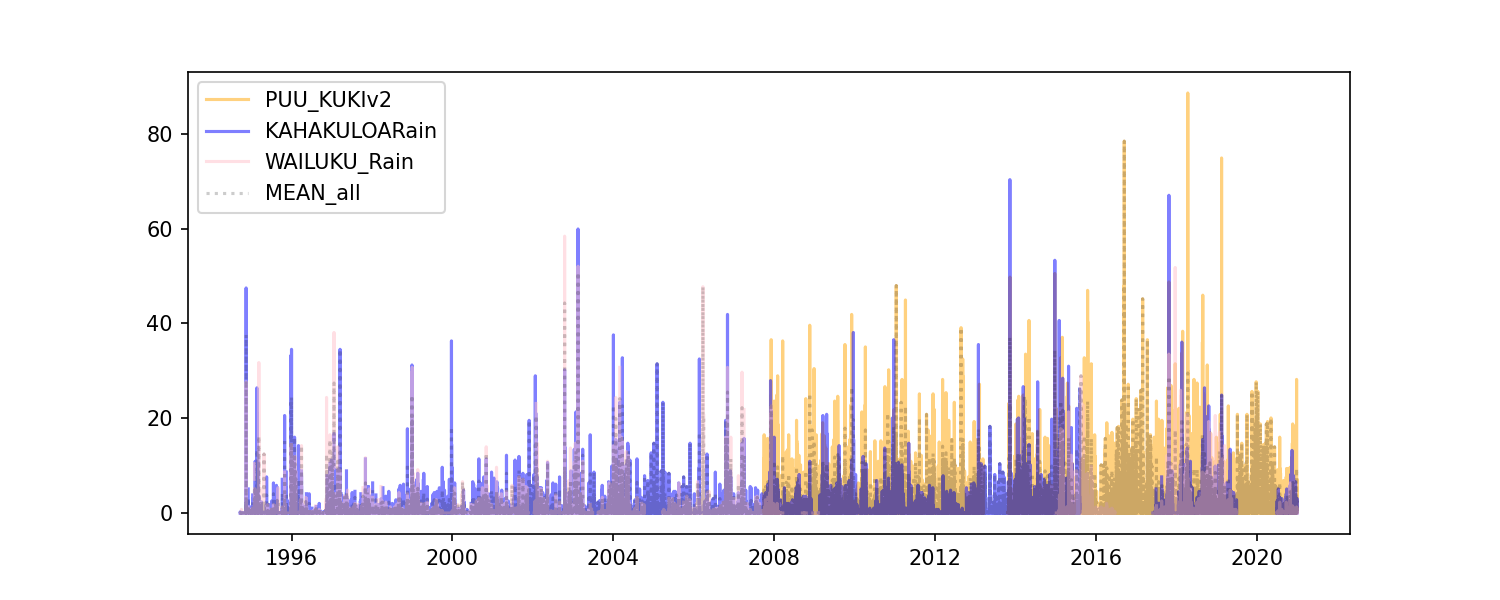

In [35]:
# DONT Resample rainfall, (it makes the nans into 0s)combine 
KAHAKULOARain_set = KAHAKULOARain.set_index('datetime')
KAHAKULOARain_set.rename(columns={'RF_mm': 'KAHAKULOARain'}, inplace=True)

PUU_KUKIv2_set = PUU_KUKIv2.set_index('datetime')
PUU_KUKIv2_set.rename(columns={'RF_mm': 'PUU_KUKIv2'}, inplace=True)

WAILUKU_Rain_set = WAILUKU_Rain.set_index('datetime')
WAILUKU_Rain_set.rename(columns={'RF_mm': 'WAILUKU_Rain'}, inplace=True)

# Merge themm all togehter
m1 = PUU_KUKIv2_set.join(KAHAKULOARain_set, how='outer')
Merged_Rainfall_mm = m1.join(WAILUKU_Rain_set)

# Create an average column of the three
Merged_Rainfall_mm['MEAN_all']= Merged_Rainfall_mm.mean(axis=1)


# Plot em all 
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(Merged_Rainfall_mm['PUU_KUKIv2'], '-', c='orange', alpha=0.5, label="PUU_KUKIv2")
ax.plot(Merged_Rainfall_mm['KAHAKULOARain'], '-', c='b', alpha=0.5, label="KAHAKULOARain")
ax.plot(Merged_Rainfall_mm['WAILUKU_Rain'], '-', c='pink', alpha=0.5, label="WAILUKU_Rain")
ax.plot(Merged_Rainfall_mm['MEAN_all'], ':', c='k', alpha=0.2, label="MEAN_all")

plt.legend()


# also create a dataframe of the biggest averaged rainfall events 
Merged_Rainfall_mm_1d = Merged_Rainfall_mm.resample('1D').sum()
# Find the biggest Flood potential days using the mean daily rainfall 
biguns_Merged_Rainfall_1d = Merged_Rainfall_mm_1d.sort_values("MEAN_all", ascending=False)
# Pull the x number of biggest events 
biguns_Merged_Rainfall_1d.reset_index(inplace=True)
biguns_Merged_Rainfall_1d = biguns_Merged_Rainfall_1d[0:10]

# Process Stream files 

Note that this leaves them at different time steps resolutions
Will need to resample to the GSSHA output timesep when using them for comparisons

<IPython.core.display.Javascript object>


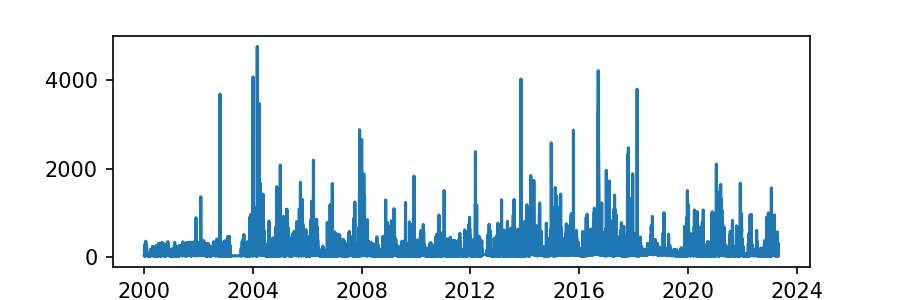

Date range = 1999-12-31 14:00:00 to 2023-04-30 14:00:00
Timestep is 0 days 00:15:00
Value range is 5.33 to 4770.0
Average value is 66.8269032889658
Median value is 30.0




<IPython.core.display.Javascript object>


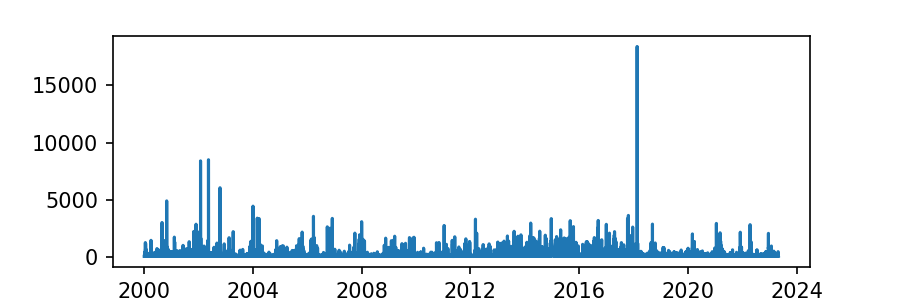

<IPython.core.display.Javascript object>


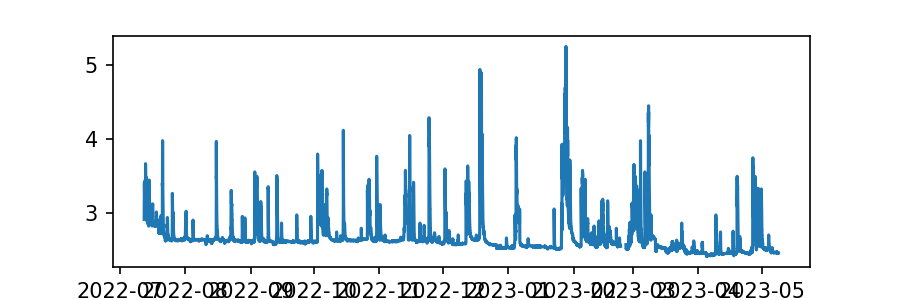

Date range = 2022-07-12 15:50:00 to 2023-05-08 20:40:00
Timestep is 0 days 00:05:00
Value range is 2.42 to 5.25
Average value is 2.675075171541934
Median value is 2.63




In [36]:
# Import Wailuku data 
WailukuFlow = pd.read_csv(os.path.join(".", "data/Streamflow", 'FlowWailukuKepaniwai_2000-01-01_to_2023-05-01.csv'))
WailukuFlow['value_time'] = pd.to_datetime(WailukuFlow['value_time'], errors='coerce')
# Clean data 
WailukuFlow = WailukuFlow[['value_time', 'value']]
WailukuFlow.rename(columns={'value': 'WailukuFlow', 'value_time':'datetime'}, inplace=True)
# Plot data 
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(WailukuFlow['datetime'],WailukuFlow['WailukuFlow'], '-',label='WailukuFlow')
TS_Describe_stats(WailukuFlow, "WailukuFlow")
WailukuFlow = WailukuFlow.set_index('datetime')  # set index to datetime index for use later 


# Import Waihehe data 
WaiheheFlow = pd.read_csv(os.path.join(".", "data/Streamflow", 'FlowWaihehe_2000-01-01_to_2023-05-01.csv'))
WaiheheFlow['value_time'] = pd.to_datetime(WaiheheFlow['value_time'], errors='coerce')
# Clean data 
WaiheheFlow = WaiheheFlow[['value_time', 'value']]
WaiheheFlow.rename(columns={'value': 'WaiheheFlow', 'value_time':'datetime'}, inplace=True)
# Plot data 
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(WaiheheFlow['datetime'],WaiheheFlow['WaiheheFlow'], '-',label='WaiheheFlow')
WaiheheFlow = WaiheheFlow.set_index('datetime')  # set index to datetime index for use later 


# Import SWaiehu data   ( note that this file was downloaded manually the API didnt work so the import is a little different than above)
SWaiehuFlow = pd.read_csv(os.path.join(".", "data/Streamflow", 'Flow_SWaiehu_2022_to_2023.csv'))
SWaiehuFlow['value_time'] = pd.to_datetime(SWaiehuFlow['value_time'], errors='coerce')
# Thre were some strings in the value column, freakin USGS....
SWaiehuFlow['value'] = SWaiehuFlow['value'].apply(lambda x: pd.to_numeric(x, errors='coerce') )
# Clean data 
SWaiehuFlow = SWaiehuFlow[['value_time', 'value']]
SWaiehuFlow.rename(columns={'value': 'SWaiehuFlow', 'value_time':'datetime'}, inplace=True)
# Plot data 
fig, ax = plt.subplots(figsize=(6, 2))
ax.plot(SWaiehuFlow['datetime'],SWaiehuFlow['SWaiehuFlow'], '-',label='SWaiehuFlow')
TS_Describe_stats(SWaiehuFlow, 'SWaiehuFlow')
SWaiehuFlow = SWaiehuFlow.set_index('datetime')  # set index to datetime index for use later 


# Mossta loop

In [28]:
# Get set up to iterate over and run the thing 

# Static parameters for rain function 
Input_Precip_df = Merged_Rainfall_mm
Precip_column_Name = "PUU_KUKIv2"
ImpPrecip_units = "mm"
gagFileFolder = os.path.join(".", "RUN")
PrjName = "Iao_v1_PrecipGag_100m"
Lat = "753250.0" 
Lon = "2310140.0"
GageName = "gag_face"
RainSeries_timestep_Mins = 60

# Static parameters for stream obs function
Input_Stream_df = WailukuFlow
StreamFlow_column_Name = "WailukuFlow"
StreamFlowObs_resample_Timestep_mins = 60   # note this will also be used to change HYD_FREQ in .prj file 

In [29]:
#Loopy parameters 

# Modify roughness parameters 
rough_vals_list = ["0.05", "0.1", "0.2", "0.3", "0.4"]

# File where the roughness parameters are defined
MapTableFile = os.path.join(".", "RUN", "{}.cmt".format(PrjName))

# List of parameters in the model
Param_list = ["-107.000000", 
              "-108.000000", 
              "-1014.000000", 
              "-1015.000000", 
              "-1016.000000", 
              "-1017.000000", 
              "-1021.000000", 
              "-1022.000000"]

Simulation time is 4380 minutes
number of time rows is 73
Run time was 1.1090183183333313 mins
The NSE is -13.461264085749455


<IPython.core.display.Javascript object>


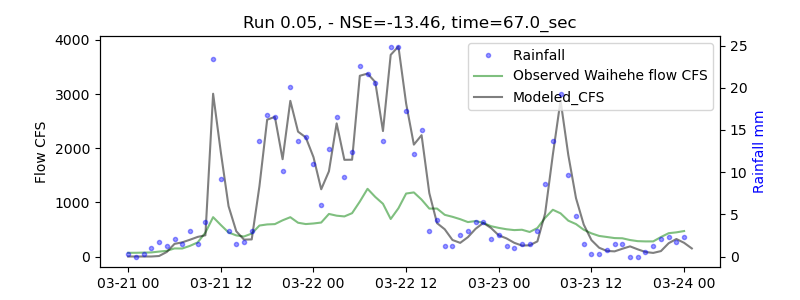

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.8366927016666674 mins
The NSE is -12.101432363880308


<IPython.core.display.Javascript object>


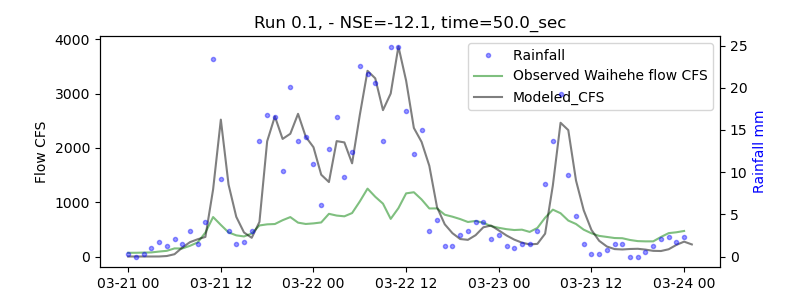

Simulation time is 4380 minutes
number of time rows is 73
Run time was 1.0176292899999984 mins
The NSE is -11.272530800618117


<IPython.core.display.Javascript object>


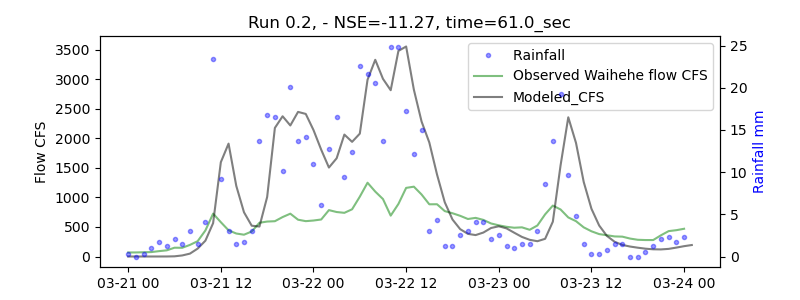

Simulation time is 4380 minutes
number of time rows is 73
Run time was 1.3403780350000034 mins
The NSE is -10.692780067231226


<IPython.core.display.Javascript object>


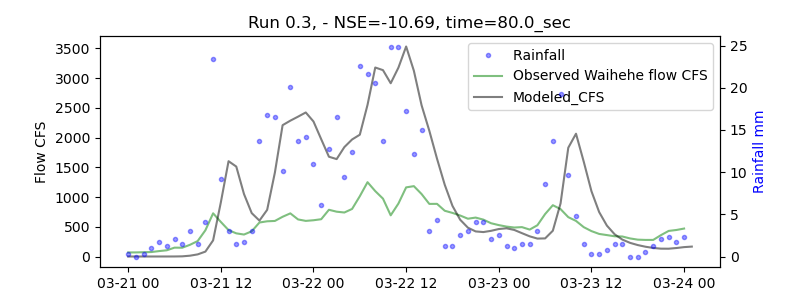

Simulation time is 4380 minutes
number of time rows is 73
Run time was 1.3370380899999872 mins
The NSE is -10.243217415831163


<IPython.core.display.Javascript object>


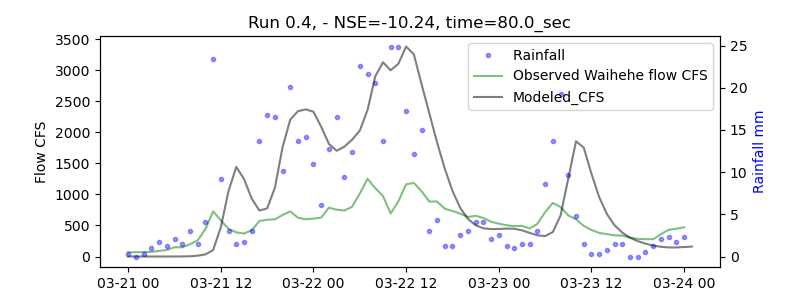

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7207937099999981 mins
The NSE is -5.977161889188005


<IPython.core.display.Javascript object>


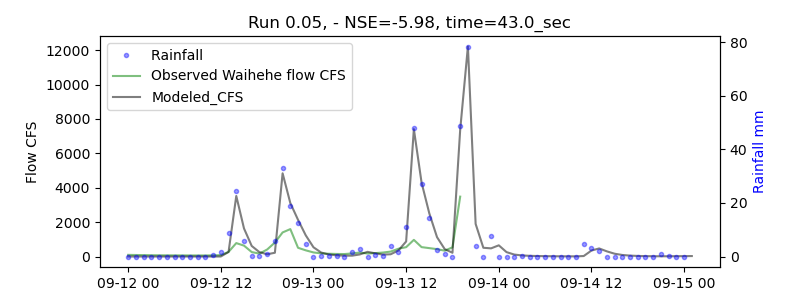

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7724058366666668 mins
The NSE is -3.2902496865195845


<IPython.core.display.Javascript object>


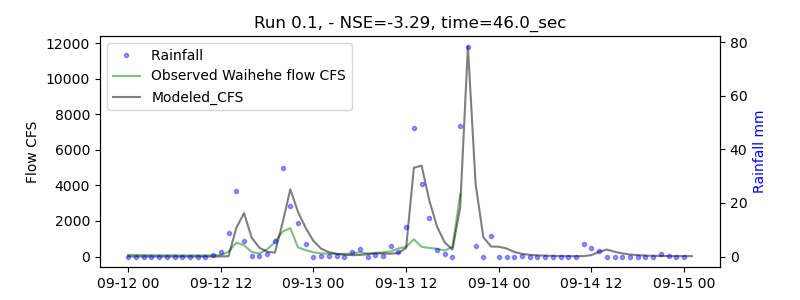

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.9530464183333304 mins
The NSE is -3.5936924257595226


<IPython.core.display.Javascript object>


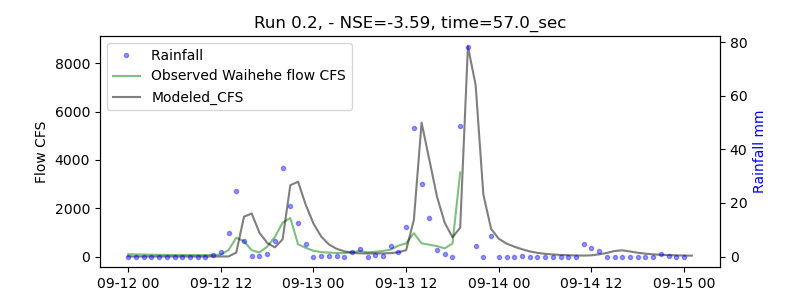

Simulation time is 4380 minutes
number of time rows is 73
Run time was 1.0053966949999904 mins
The NSE is -3.160471853750675


<IPython.core.display.Javascript object>


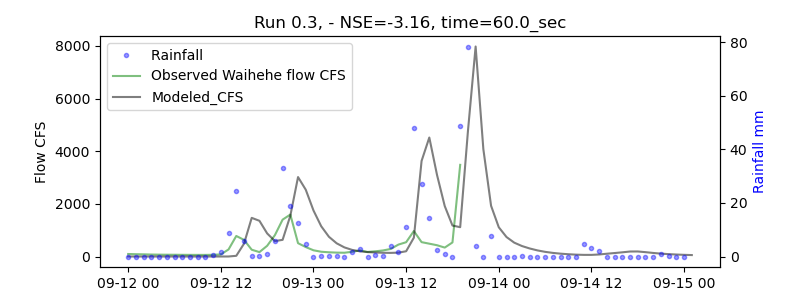

Simulation time is 4380 minutes
number of time rows is 73
Run time was 1.038538846666673 mins
The NSE is -2.670159791919182


<IPython.core.display.Javascript object>


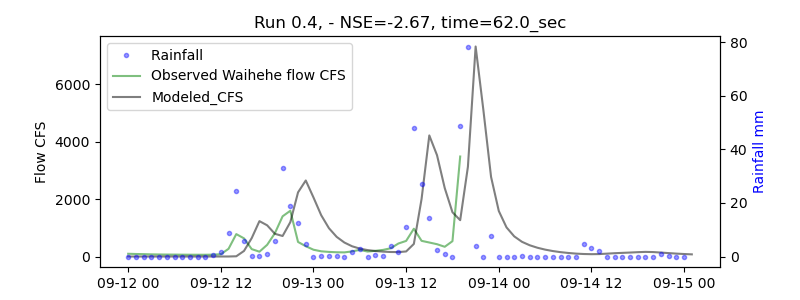

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.49377441666665617 mins
The NSE is -17.73923798660934


<IPython.core.display.Javascript object>


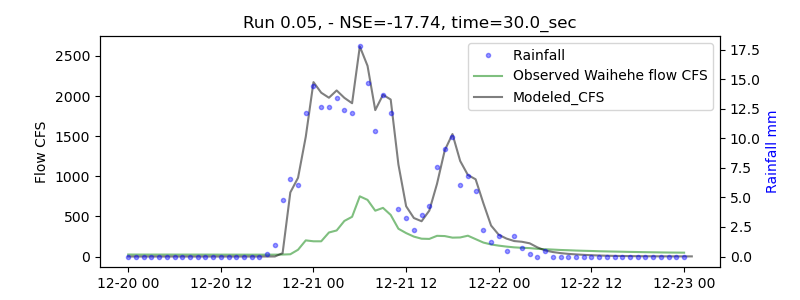

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.45681693166666265 mins
The NSE is -17.198820816304274


<IPython.core.display.Javascript object>


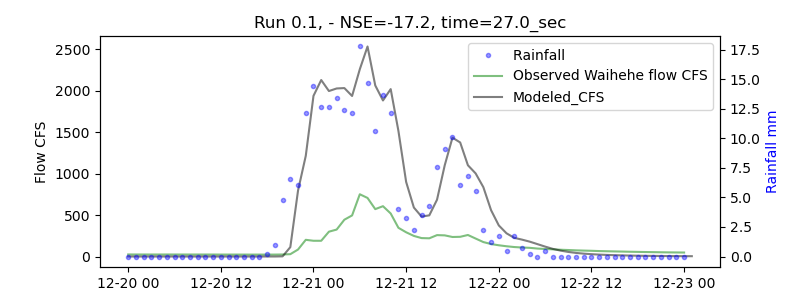

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.408723815 mins
The NSE is -16.36102815739274


C:\Users\CS\AppData\Local\Temp\ipykernel_16392\292440688.py:77: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(8, 3))


<IPython.core.display.Javascript object>


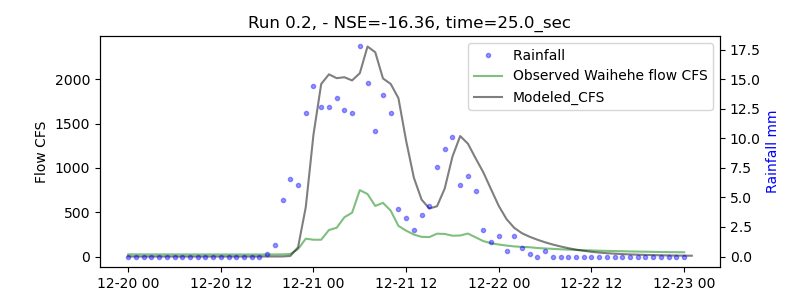

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.67728408333334 mins
The NSE is -15.705478941656303


<IPython.core.display.Javascript object>


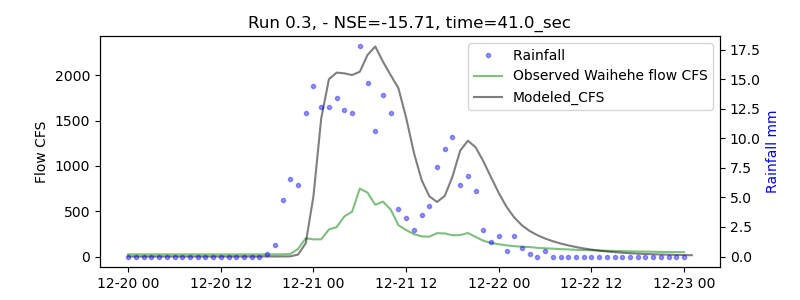

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.6386961583333232 mins
The NSE is -15.127670079728798


<IPython.core.display.Javascript object>


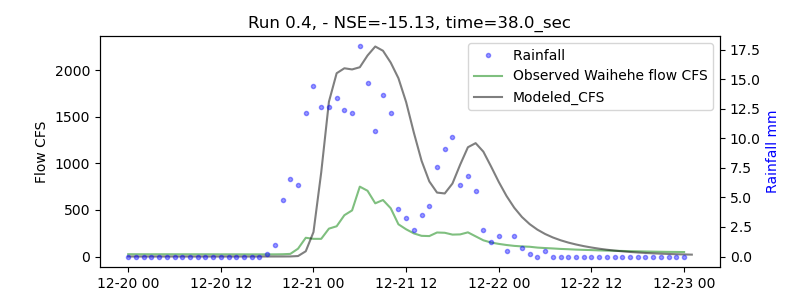

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.5412628849999995 mins
The NSE is -99.25440841443796


<IPython.core.display.Javascript object>


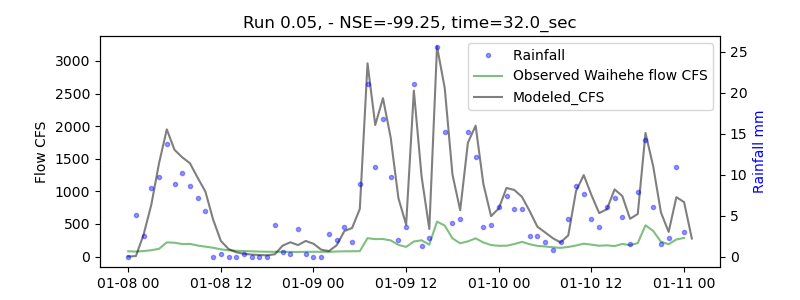

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7289863766666713 mins
The NSE is -86.03608254429804


<IPython.core.display.Javascript object>


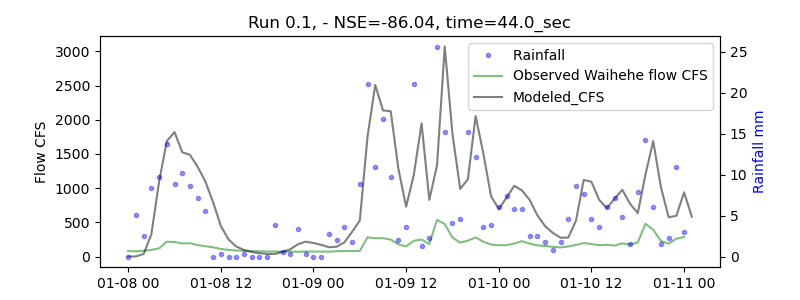

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7509780433333314 mins
The NSE is -78.63454188293973


<IPython.core.display.Javascript object>


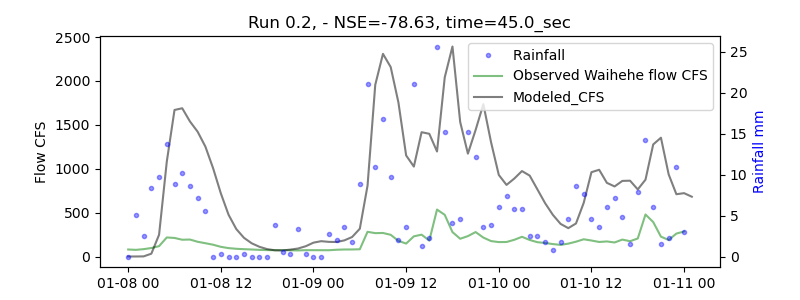

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7698261816666673 mins
The NSE is -74.61524345192797


<IPython.core.display.Javascript object>


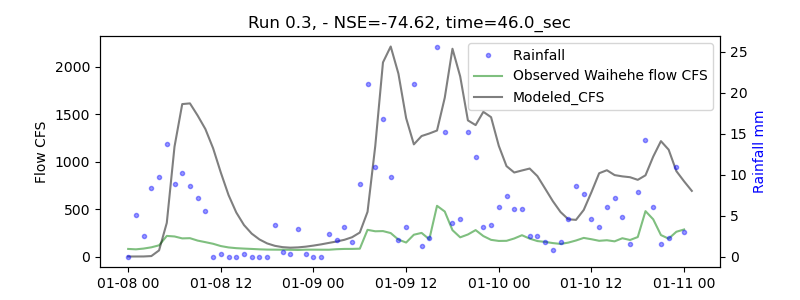

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.9409378383333357 mins
The NSE is -71.14222747581194


<IPython.core.display.Javascript object>


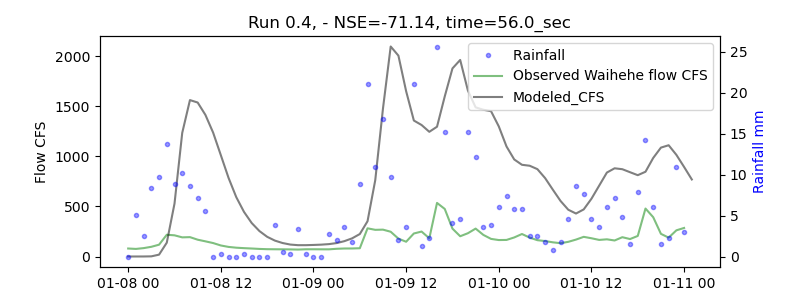

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.45646815833333676 mins
The NSE is -7.9195480827679035


<IPython.core.display.Javascript object>


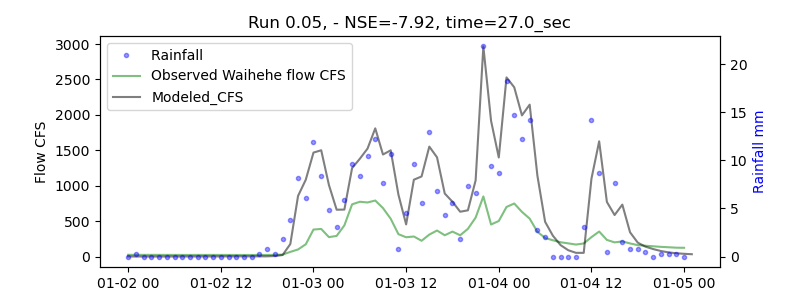

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.608690630000001 mins
The NSE is -7.413188949166225


<IPython.core.display.Javascript object>


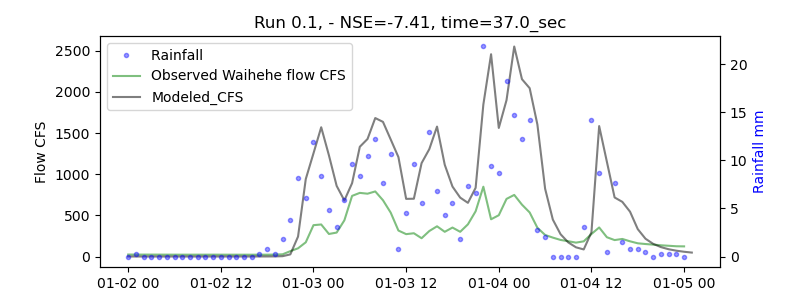

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.5930948666666761 mins
The NSE is -6.983664471950249


<IPython.core.display.Javascript object>


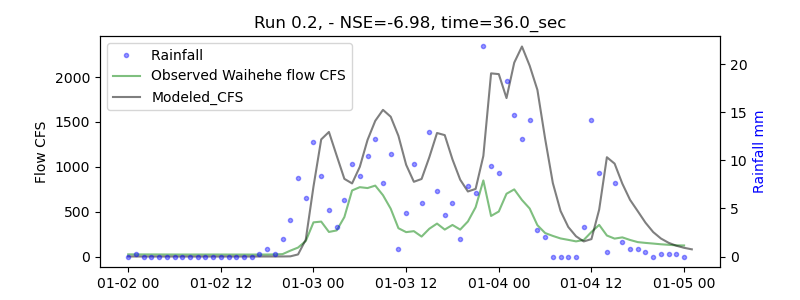

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.6392391849999968 mins
The NSE is -6.7380876722781675


<IPython.core.display.Javascript object>

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.6933544583333363 mins
The NSE is -6.536167481471152


<IPython.core.display.Javascript object>


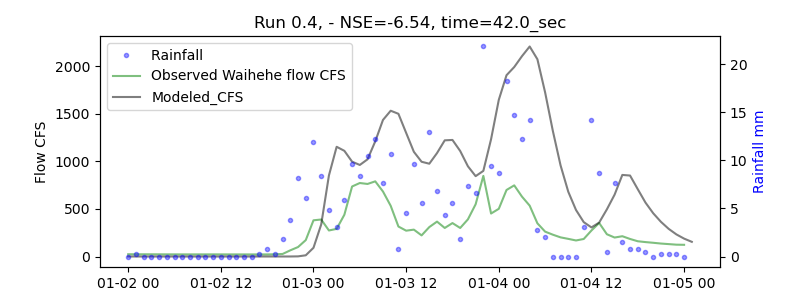

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.004659396666662967 mins
The NSE is nan


C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_16392\1865593867.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


<IPython.core.display.Javascript object>


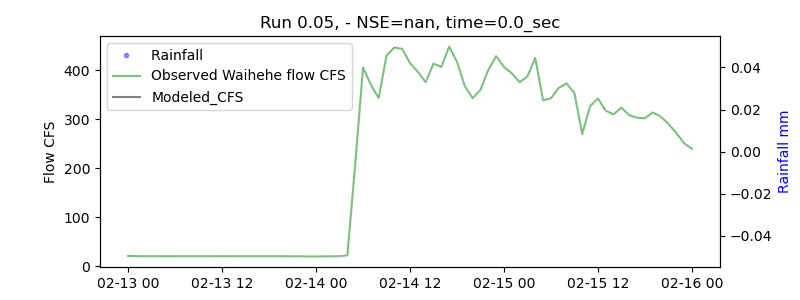

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.0033096833333274844 mins
The NSE is nan


C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_16392\1865593867.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


<IPython.core.display.Javascript object>


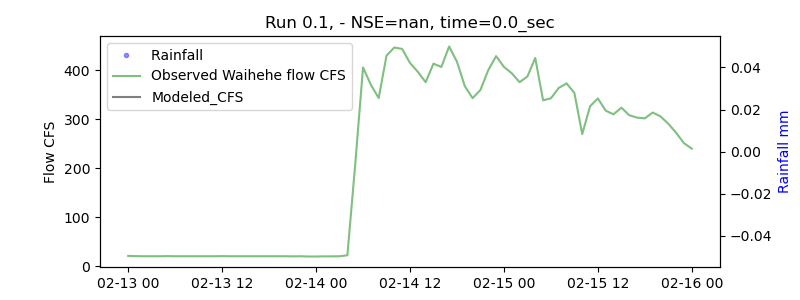

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.003295839999994617 mins
The NSE is nan


C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_16392\1865593867.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


<IPython.core.display.Javascript object>


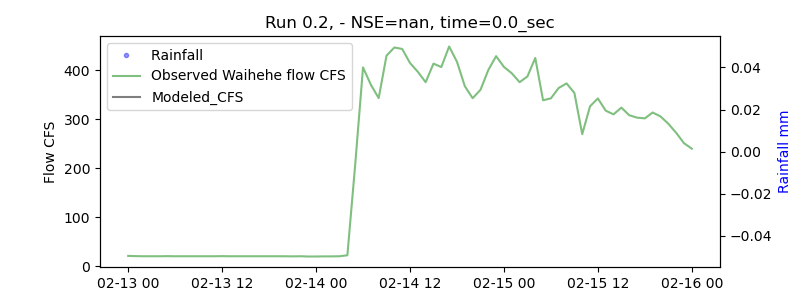

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.003494288333331497 mins
The NSE is nan


C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_16392\1865593867.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


<IPython.core.display.Javascript object>


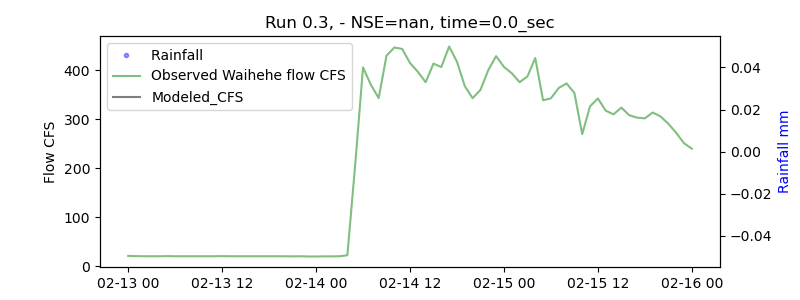

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.0032297033333331155 mins
The NSE is nan


C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_16392\1865593867.py:139: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


<IPython.core.display.Javascript object>


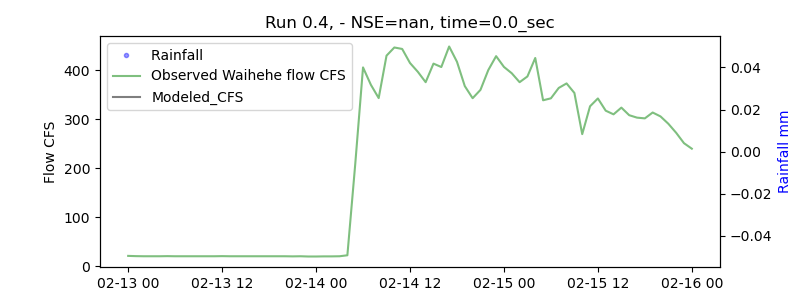

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.3787717500000023 mins
The NSE is -613.8728853207085


<IPython.core.display.Javascript object>


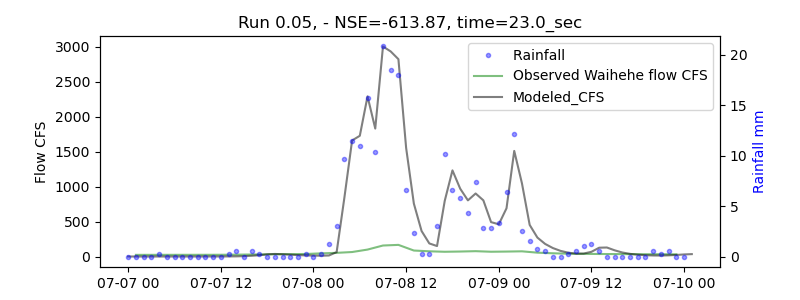

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.4197821916666726 mins
The NSE is -584.4864148175362


<IPython.core.display.Javascript object>


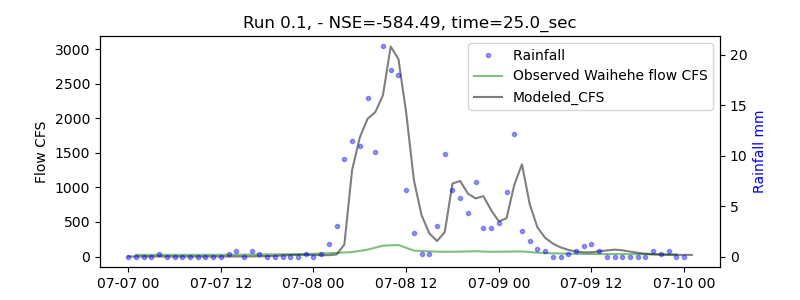

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.453495018333327 mins
The NSE is -550.1579751751516


<IPython.core.display.Javascript object>


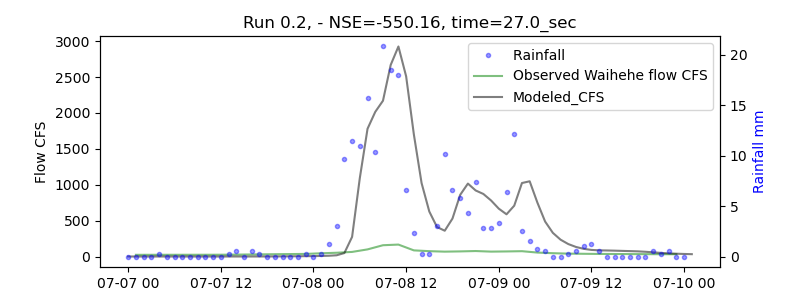

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.5065029316666672 mins
The NSE is -525.4004049987694


<IPython.core.display.Javascript object>


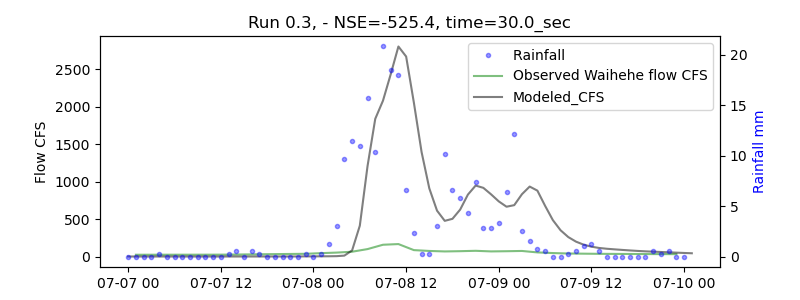

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.5060267316666796 mins
The NSE is -503.63753908520215


<IPython.core.display.Javascript object>


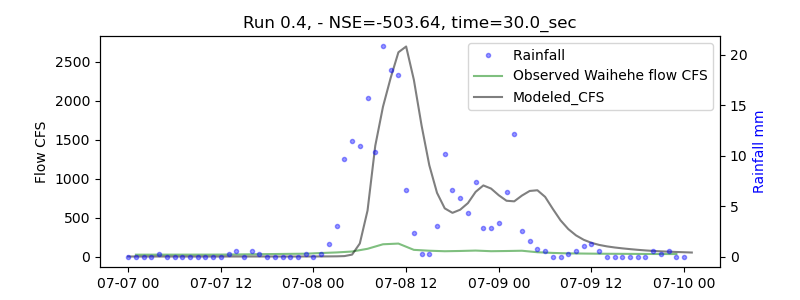

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.6160877599999973 mins
The NSE is -189.25038603319757


<IPython.core.display.Javascript object>


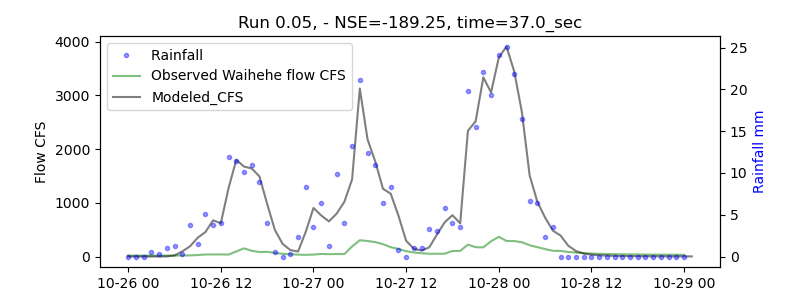

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.677558229999992 mins
The NSE is -183.76245831116896


<IPython.core.display.Javascript object>


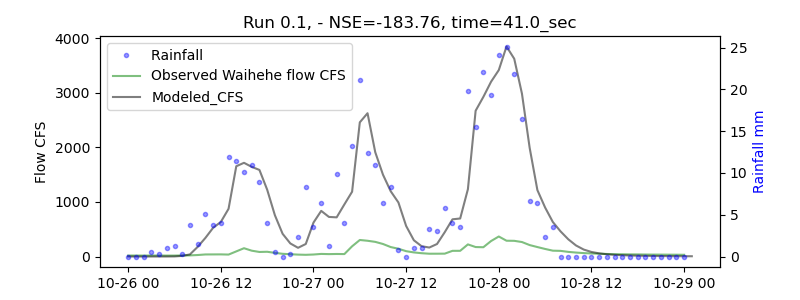

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.8842599233333355 mins
The NSE is -177.25565994340417


<IPython.core.display.Javascript object>


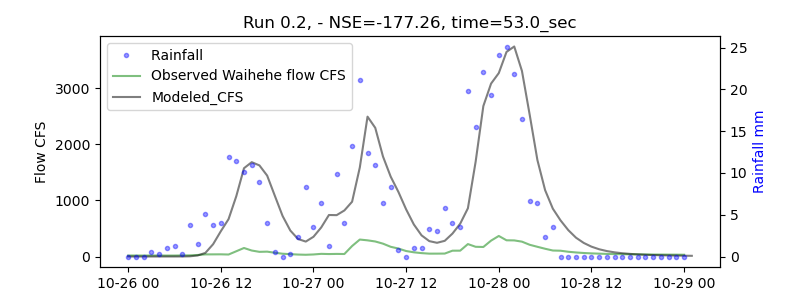

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.869601975000008 mins
The NSE is -171.99207150917073


<IPython.core.display.Javascript object>


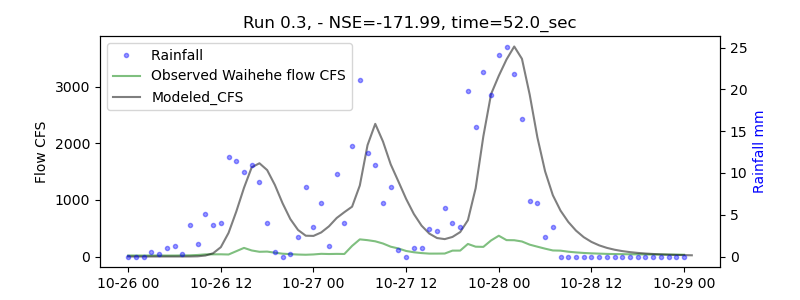

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.9875889850000021 mins
The NSE is -167.23605993412042


<IPython.core.display.Javascript object>


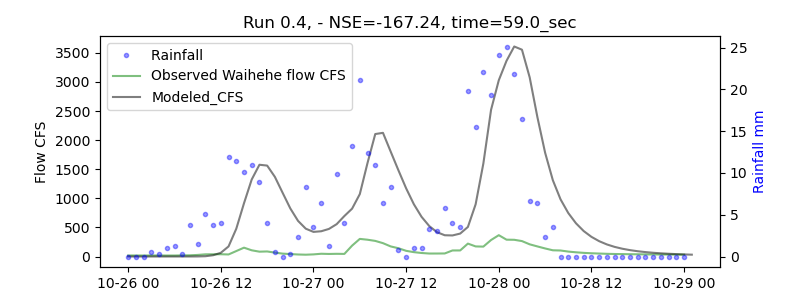

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.5062554700000116 mins
The NSE is -4.798161113262366


<IPython.core.display.Javascript object>


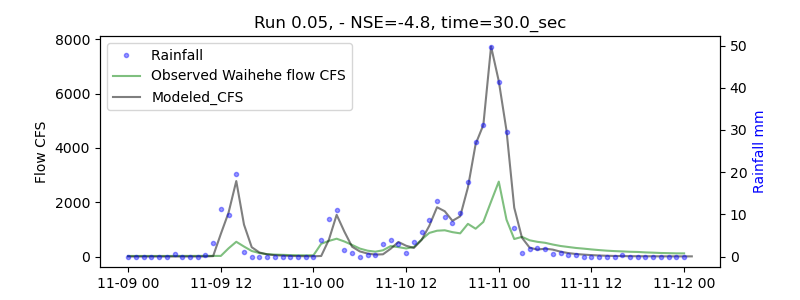

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.72126479333333 mins
The NSE is -4.4115184472935


<IPython.core.display.Javascript object>


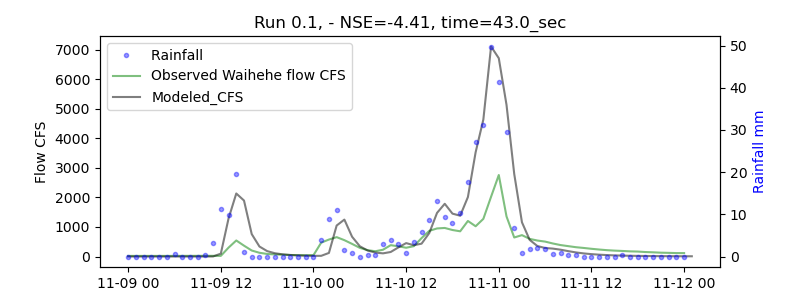

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7354655833333406 mins
The NSE is -4.150186517336145


<IPython.core.display.Javascript object>


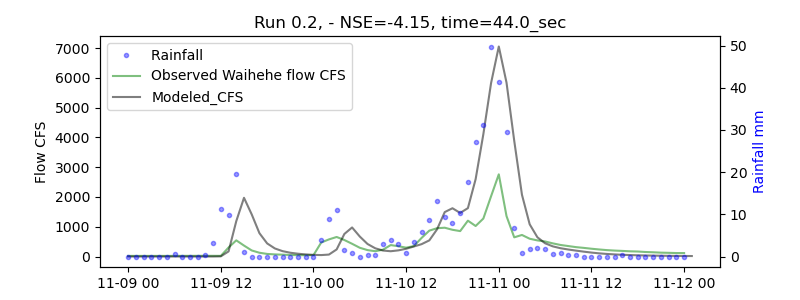

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.7163424600000022 mins
The NSE is -4.100677596105357


<IPython.core.display.Javascript object>


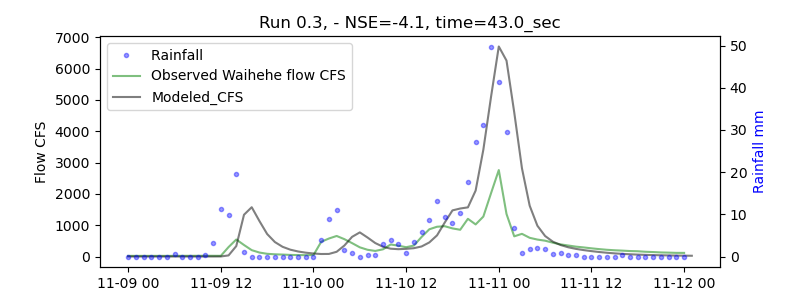

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.8688504316666543 mins
The NSE is -4.070757090336593


<IPython.core.display.Javascript object>


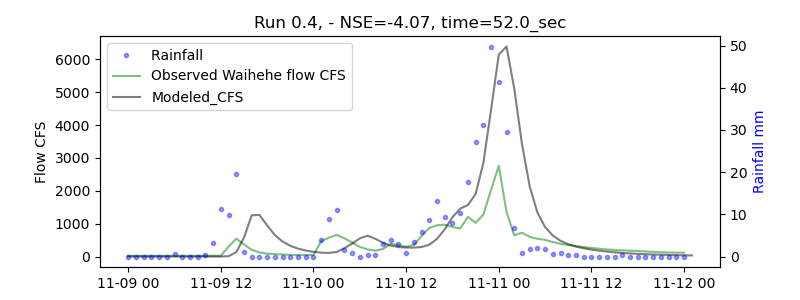

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.39972412833334 mins
The NSE is -489.4385164237811


<IPython.core.display.Javascript object>

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.4667245999999977 mins
The NSE is -462.49138175330586


<IPython.core.display.Javascript object>

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.541947213333333 mins
The NSE is -427.89637063041755


<IPython.core.display.Javascript object>

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.557630323333342 mins
The NSE is -400.5251765059499


<IPython.core.display.Javascript object>

Simulation time is 4380 minutes
number of time rows is 73
Run time was 0.5799925566666692 mins
The NSE is -377.08711556152116


<IPython.core.display.Javascript object>

In [30]:
# Save lists 
Param_Vals_list = []
run_time_list =[]
NSE_list = []
start_list = []
end_list = []
Raintot_list = []

##### Loop over the biggest rainfall events 
for row in biguns_Merged_Rainfall_1d.iterrows(): 
    bigdate = row[1]['datetime']
    Raintot = row[1]['MEAN_all']
    StartDate = (bigdate-timedelta(days=1)).strftime('%Y-%m-%d %H:%M')
    EndDate = (bigdate+timedelta(days=2)).strftime('%Y-%m-%d %H:%M')
    
##### Now also loop over the roughness values 
    for i in rough_vals_list:

        # Switch out each parameter with the Uniform value 
        for Param in Param_list:
            cmt_prama_jama(MapTableFile, Param, i)

    ### Note even if not modifying these parameters need to run ALL code used to create model after the WMS save   
    ### Since its all erased at the end of the block 

        # rain gauge maker code block ready to loop over start and end dates
        Run_Length_mins, SlicedRainFrame = make_rain_gag_file(PrjName, Input_Precip_df, Precip_column_Name, gagFileFolder, StartDate, EndDate, Lat, Lon, 
                               GageName, RainSeries_timestep_Mins, ImpPrecip_units)

    ######  need to write in the rangauge dates (runtime) in the .prj file this does that and other modicifations to it ###
        file_path = os.path.join(".", "RUN")
        prj_name  = PrjName

        # write in the total run time to the project file 
        card_name = "TOT_TIME"
        Mod_Value = Run_Length_mins
        modify_prj_file(file_path, prj_name, card_name, Mod_Value)

        # Write in the hydrograph write frequency to the project (needs to standardize with the streamflow resampling timestep )
        card_name = "HYD_FREQ"
        Mod_Value = StreamFlowObs_resample_Timestep_mins
        modify_prj_file(file_path, prj_name, card_name, Mod_Value)


        ##########    RUN THE MODEL   #################
        # Run the GSSHA process in the command line 
        start_time = timeit.default_timer()     ###### Timer function start

        os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
        subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
        os.chdir(os.path.join(".."))                # Change back out of run directory 

        elapsed = timeit.default_timer() - start_time        ###### Timer function End, now time in seconds lives in elapsed
        print("Run time was {} mins".format(elapsed/60))

        # Postprocessing block 
        # Process the Run's Output hydrograph into a dataframe 
        OutletFile = os.path.join(".", "RUN", PrjName)+".otl"
        OutHydro = process_otl_file(StartDate, OutletFile)

        # slice the desired streamflow obs to the correct period 
        SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate, 
                                                  StreamFlowObs_resample_Timestep_mins)

        # NSE calculation          # Note this has hourly resampling hard coded in, not sure if need to change someday 
        predictions = OutHydro
        targets = SlicedStreamflow_df.resample('60T').mean().interpolate()
        NSE_Frame = predictions.join(targets, how='inner')
        NSE_stat = nse(NSE_Frame['CFS'].values, NSE_Frame[StreamFlow_column_Name].values)
        print("The NSE is {}".format(NSE_stat))


        # plot em 
        # For some reason need to cast the rainfall as a number not object?
        SlicedRainFrame[Precip_column_Name] = SlicedRainFrame[Precip_column_Name].apply(lambda x: float(x)) 

        fig, ax = plt.subplots(figsize=(8, 3))
        ax2 = ax.twinx()
        lns0 = ax2.plot(SlicedRainFrame[Precip_column_Name], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
        lns1 = ax.plot(SlicedStreamflow_df[StreamFlow_column_Name], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
        lns2 = ax.plot(OutHydro['CFS'], '-', c='k', alpha=0.5, label="Modeled_CFS")   # plot modeled 
        ax.set_ylabel("Flow CFS")
        ax2.set_ylabel("Rainfall mm", color='b')
        # Wierd stuff for a twinned  axis legend
        lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc=0)

        plt.title("Run {}, - NSE={}, time={}_sec".format(i,
                                                     round(NSE_stat, 2), round(elapsed, 0)))
        # save fig on disc
        plt.savefig(os.path.join('.', 'Figures_temp', "TestRun {}- {} to {}.png".format(i, 
                                                                                        StartDate[:10], EndDate[:10])))
        # Save info
        Param_Vals_list.append(i)
        run_time_list.append(elapsed) 
        NSE_list.append(NSE_stat)
        start_list.append(StartDate)
        end_list.append(EndDate)
        Raintot_list.append(Raintot)
        
        
        # Toss this dataframe into a csv incase the kernal dies
        Save_data = pd.DataFrame({'Param_Vals':Param_Vals_list, 
                 "Run_time_secs":run_time_list,
                 "NSE":NSE_list, 
                 "start":start_list,
                 "end":end_list, 
                 "Total_24hr_rain":Raintot_list})
        
        Save_data.to_csv(os.path.join('.', 'Figures_temp', "Run_Metadata_lists.csv")) 

        #### refreshing the model for each parameter run 
        # Nuke out the RUN directory to start fresh
        for f in os.listdir("RUN"):  os.remove(os.path.join("RUN", f))  
        # copy out the project filesfrom pristine to RUN  
        copy_tree('PRISTINE_MODEL_COPY', "RUN") 

# Development bin 

In [37]:
# Get set up to iterate over and run the thing 

# Static parameters for rain function 
Input_Precip_df = Merged_Rainfall_mm
Precip_column_Name = "PUU_KUKIv2"
ImpPrecip_units = "mm"
gagFileFolder = os.path.join(".", "RUN")
PrjName = "Iao_v1_Soils_inflf_100m"
Lat = "753250.0" 
Lon = "2310140.0"
GageName = "gag_face"
RainSeries_timestep_Mins = 60

# Static parameters for stream obs function
Input_Stream_df = WailukuFlow
StreamFlow_column_Name = "WailukuFlow"
StreamFlowObs_resample_Timestep_mins = 60   # note this will also be used to change HYD_FREQ in .prj file 

In [38]:
# rain gauge maker code block ready to loop over start and end dates

StartDate = "2018-02-17 00:00"
EndDate = "2018-02-21 00:00"

Run_Length_mins, SlicedRainFrame = make_rain_gag_file(PrjName, Input_Precip_df, Precip_column_Name, gagFileFolder, StartDate, EndDate, Lat, Lon, 
                       GageName, RainSeries_timestep_Mins, ImpPrecip_units)

Simulation time is 5820 minutes
number of time rows is 97


In [39]:

file_path = os.path.join(".", "RUN")
prj_name  = PrjName

# write in the total run time to the project file 
card_name = "TOT_TIME"
Mod_Value = Run_Length_mins
modify_prj_file(file_path, prj_name, card_name, Mod_Value)

# Write in the hydrograph write frequency to the project (needs to standardize with the streamflow resampling timestep )
card_name = "HYD_FREQ"
Mod_Value = StreamFlowObs_resample_Timestep_mins
modify_prj_file(file_path, prj_name, card_name, Mod_Value)

In [17]:
# Modify roughness parameters 

# File where the roughness parameters are defined
MapTableFile = os.path.join(".", "RUN", "{}.cmt".format(PrjName))

# just using a uniform value for now
Uniform_Val = "0.15"

# List of parameters in the model
Param_list = ["-107.000000", 
              "-108.000000", 
              "-1014.000000", 
              "-1015.000000", 
              "-1016.000000", 
              "-1017.000000", 
              "-1021.000000", 
              "-1022.000000"]

# Switch out each parameter with the Uniform value 
for Param in Param_list:
    cmt_prama_jama(MapTableFile, Param, Uniform_Val)

In [41]:
# Modify infiltration parameters 
# File where the roughness parameters are defined
MapTableFile = os.path.join(".", "RUN", "{}.cmt".format(PrjName))

# HYDR_COND in cm/hr
HYDR_COND_options = ["0.1", "0.5", "1", "10", "100"]

#CAPIL_HEAD  (in cm)
CAPIL_HEAD_options = ["1", "5", "10", "50", "100"]

# POROSITY m^3/m^3
POROSITY_options = ['0.05', '0.1', "0.2", "0.4", "0.8"]

#PORE_INDEX = cm/cm
PORE_INDEX_options  = ['0.05', '0.1', "0.2", "0.4", "0.8"]

# RESID_SATm^3/m^3
RESID_SAT_options = ['0.01', '0.05', "0.1", "0.2", "0.3"]

# FIELD_CAPACITY m^3/m^3
FIELD_CAPACITY_options= ['0.05', '0.1', "0.2", "0.4", "0.8"]

# WILTING_PT m^3/m^3 
WILTING_PT_options= ['0.05', '0.1', "0.2", "0.4", "0.8"]

Param_dic = {"-251.000000":HYDR_COND_options[idx], 
              "-252.000000":CAPIL_HEAD_options[idx], 
              "-253.000000":POROSITY_options[idx], 
              "-254.000000": PORE_INDEX_options[idx], 
              "-255.000000": RESID_SAT_options[idx], 
              "-256.000000": FIELD_CAPACITY_options[idx], 
              "-257.000000":WILTING_PT_options[idx], 
              "-2211.000000":HYDR_COND_options[idx], 
              "-2212.000000":CAPIL_HEAD_options[idx], 
              "-2213.000000":POROSITY_options[idx], 
              "-2214.000000":PORE_INDEX_options[idx], 
              "-2215.000000":RESID_SAT_options[idx], 
              "-2216.000000":FIELD_CAPACITY_options[idx], 
              "-2217.000000":WILTING_PT_options[idx]}


Run_idx = [0, 1, 2, 3, 4]
for idx in Run_idx:
    print(Param_dic.keys())


NameError: name 'idx' is not defined

In [ ]:

RESID_SAT_options = ['0.01', '0.05', "0.1", "0.2", "0.3"]

# FIELD_CAPACITY m^3/m^3
FIELD_CAPACITY_options= ['0.05', '0.1', "0.2", "0.4", "0.8"]

# WILTING_PT m^3/m^3 
WILTING_PT_options= ['0.05', '0.1', "0.2", "0.4", "0.8"]

In [18]:
# Here is an operational model runner code block 

##########    RUN THE MODEL   #################
# Run the GSSHA process in the command line 
start_time = timeit.default_timer()     ###### Timer function start

os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
os.chdir(os.path.join(".."))                # Change back out of run directory 

elapsed = timeit.default_timer() - start_time        ###### Timer function End, now time in seconds lives in elapsed

print("Run time was {} mins".format(elapsed/60))

Run time was 0.3586159083333314 mins


The NSE is 0.22763199644121457


<IPython.core.display.Javascript object>


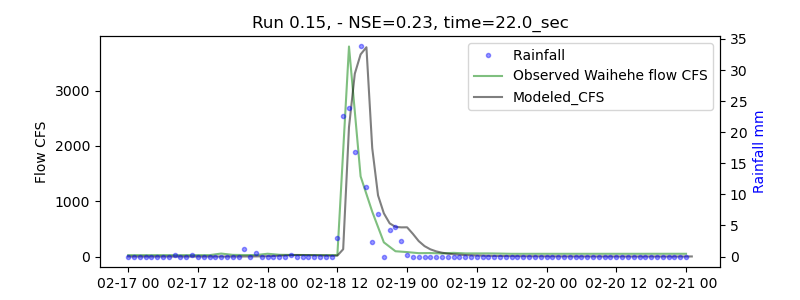

In [19]:
# Postprocessing block 

# Process the Run's Output hydrograph into a dataframe 
OutletFile = os.path.join(".", "RUN", PrjName)+".otl"
OutHydro = process_otl_file(StartDate, OutletFile)

# slice the desired streamflow obs to the correct period 
SlicedStreamflow_df = Isolate_Stream_Data(Input_Stream_df, StreamFlow_column_Name, StartDate, EndDate, 
                                          StreamFlowObs_resample_Timestep_mins)

# NSE calculation          # Note this has hourly resampling hard coded in, not sure if need to change someday 
#predictions = OutHydro['CFS'].to_numpy()
#targets = SlicedStreamflow_df.resample('60T').mean().to_numpy()
#NSE_stat = nse(predictions, np.nan_to_num(targets))
#print("The NSE is {}".format(NSE_stat))

predictions = OutHydro
targets = SlicedStreamflow_df.resample('60T').mean().interpolate()
NSE_Frame = predictions.join(targets, how='inner')
NSE_stat = nse(NSE_Frame['CFS'].values, NSE_Frame[StreamFlow_column_Name].values)
print("The NSE is {}".format(NSE_stat))


# plot em 
# For some reason need to cast the rainfall as a number not object?
SlicedRainFrame[Precip_column_Name] = SlicedRainFrame[Precip_column_Name].apply(lambda x: float(x)) 

fig, ax = plt.subplots(figsize=(8, 3))
ax2 = ax.twinx()
lns0 = ax2.plot(SlicedRainFrame[Precip_column_Name], '.', c='b', alpha=0.4, label="Rainfall ")   # Plot rainfall 
lns1 = ax.plot(SlicedStreamflow_df[StreamFlow_column_Name], '-', c='g', alpha=0.5, label="Observed Waihehe flow CFS") # Plot Observed
lns2 = ax.plot(OutHydro['CFS'], '-', c='k', alpha=0.5, label="Modeled_CFS")   # plot modeled 
ax.set_ylabel("Flow CFS")
ax2.set_ylabel("Rainfall mm", color='b')
# Wierd stuff for a twinned  axis legend
lns = lns0+lns1+lns2; labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

plt.title("Run {}, - NSE={}, time={}_sec".format(Uniform_Val,
                                             round(NSE_stat, 2), round(elapsed, 0)))
# save fig
plt.savefig(os.path.join('.', 'Figures_temp', "20_Run {}- {} to {}.png".format(Uniform_Val, 
                                                                                StartDate[:10], EndDate[:10])))



rando notes
Note at 60 sec time step = 208 sec 
at 30 sec step = 219 sec
at 15 = 204 sec 
at 5 sec = 244 sec 
at 15 sec but Quiet card = 207 sec 